# Install Library

In [1]:
import numpy as np
from dateutil.tz import EPOCH
from torch.nn import MSELoss
from triton.backends.amd.driver import FLOAT_STORAGE_TYPE
!uv pip install torch
!uv pip install torchvision
!uv pip install numpy
!uv pip install matplotlib
!uv pip install scikit-learn

Audited 1 package in 2ms
Audited 1 package in 2ms
Audited 1 package in 1ms
Audited 1 package in 2ms
Audited 1 package in 1ms


# Set Dataset & Dataloader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [3]:
BATCH_SIZE = 32

In [4]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

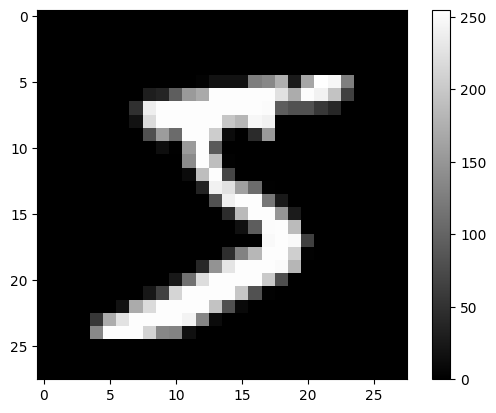

In [5]:
plt.imshow(train_DS.data[0], cmap='gray')
plt.colorbar()

In [6]:
from torch.utils.data import DataLoader

In [7]:
train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
x_batch, y_batch = next(iter(train_DL))

In [9]:
x_batch.shape

torch.Size([32, 1, 28, 28])

# Set Model

In [10]:
import torch
from torch import nn

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE}')

Using cuda


## AutoEncoder

In [12]:
class Flatten(nn.Module):
    def forward(self, x):
        batch = x.shape[0]
        return x.reshape(batch, -1)


class DeFlatten(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.k = x

    def forward(self, x):
        batch = x.shape[0]
        # x.shape[1] = self.k * w^2
        # x.shape[1] // self.k ** 0.5 = w
        width = int((x.shape[1] // self.k) ** 0.5)
        return x.reshape(batch, self.k,width,width)


In [13]:
class AutoEncoderConv(nn.Module):
    def __init__(self):
        super().__init__()
        k = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=k, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=k, out_channels=k * 2, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=k * 2, out_channels=k * 4, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(in_features=1024, out_features=10),
            nn.ReLU(),
            # nn.Linear(in_features=512, out_features=10),
            # nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=10, out_features=1024),
            nn.ReLU(),
            # nn.Linear(in_features=512, out_features=1024),
            # nn.ReLU(),
            DeFlatten(k * 4),
            nn.ConvTranspose2d(in_channels=k * 4, out_channels=k * 2, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=k * 2, out_channels=k, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=k, out_channels=1, kernel_size=3, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode, encode

# Train Model

In [14]:
from torch import optim

In [15]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot(model):
    with torch.no_grad():
        for data in train_DL:

            inputs = data[0].to(DEVICE)
            outputs = model(inputs)

            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 8 # 시각화 전체 너비
    rows = 4 # 시각화 전체 높이

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [16]:
def cluster_dist(enc, centers):
    expanded_enc = enc.unsqueeze(1) # (batch, 1, 10)
    expanded_cen = centers.unsqueeze(0) # (1, 10, 10)
    distance = torch.sum((expanded_enc-expanded_cen)**2, dim=2)
    min_dist,_ = torch.min(distance, dim=1)
    return torch.mean(min_dist)

In [17]:
def train(model:nn.Module):
    epoch = 31
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    losses = []
    for e in range(epoch):
        epoch_loss = 0.0
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            optimizer.zero_grad()
            x_hat,enc = model(x_batch)

            loss = criterion(x_hat, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        cost = epoch_loss / len(train_DL)
        print(f'Epoch {e}: {cost}')
        losses.append(epoch_loss)

In [18]:
autoencoder = AutoEncoderConv().to(DEVICE)
autoencoder

AutoEncoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten()
    (7): Linear(in_features=1024, out_features=10, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): DeFlatten()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
train(autoencoder)

In [ ]:
save_model_path = './results/autoencoder.pt'

In [ ]:
torch.save(autoencoder.state_dict(), save_model_path)

# Clustering

In [ ]:
autoencoder = AutoEncoderConv().to(DEVICE)
autoencoder.load_state_dict(torch.load(save_model_path, map_location=DEVICE))

## K-Means

In [ ]:
from sklearn.cluster import KMeans
autoencoder.eval()
all_encoded_vectors = []
with torch.no_grad():
    for x_batch, _ in train_DL:
        x_batch = x_batch.to(DEVICE)

        _, encode = autoencoder(x_batch)
        all_encoded_vectors.append(encode.to('cpu'))
all_encoded_vectors = torch.cat(all_encoded_vectors).numpy()

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
kmeans.fit(all_encoded_vectors)
cluster_centers = torch.from_numpy(kmeans.cluster_centers_).float().to(DEVICE)

# Test Model

In [ ]:
criterion = nn.MSELoss()
def test(model):
    with torch.no_grad():
        t_loss = 0.0
        for x_batch, _ in test_DL:
            x_batch = x_batch.to(DEVICE)
            x_hat,_ = model(x_batch)

            loss = criterion(x_hat, x_batch)
            t_loss += loss
        t_loss /= len(test_DL)
    print(t_loss)

In [ ]:
test(autoencoder)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
autoencoder.eval()
test_latent_vectors = []
test_labels = []
with torch.no_grad():
    for data, labels in test_DL:
        img = data.to(DEVICE)
        _, latent = autoencoder(img)
        test_latent_vectors.append(latent.cpu())
        test_labels.append(labels)
test_latent_vectors = torch.cat(test_latent_vectors).numpy()
test_labels = torch.cat(test_labels).numpy()

In [ ]:
# t-SNE로 2차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_tsne = tsne.fit_transform(test_latent_vectors)

# 시각화
plt.figure(figsize=(12, 10))
for i in range(10):
    indices = test_labels == i
    plt.scatter(latent_tsne[indices, 0], latent_tsne[indices, 1], label=str(i), alpha=0.7)
plt.legend()
plt.title("t-SNE visualization of MNIST latent space")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
test_pred = kmeans.predict(test_latent_vectors)

In [ ]:
adjusted_rand_score(test_labels, test_pred)

In [ ]:
from scipy.stats import mode

In [ ]:
for i in range(10):
    get_label = mode(test_labels[test_pred == i])[0]
    print(get_label)